_mylearning_beforepretraing_checkinhg_loss with _dataset_like_harry_gpt2_

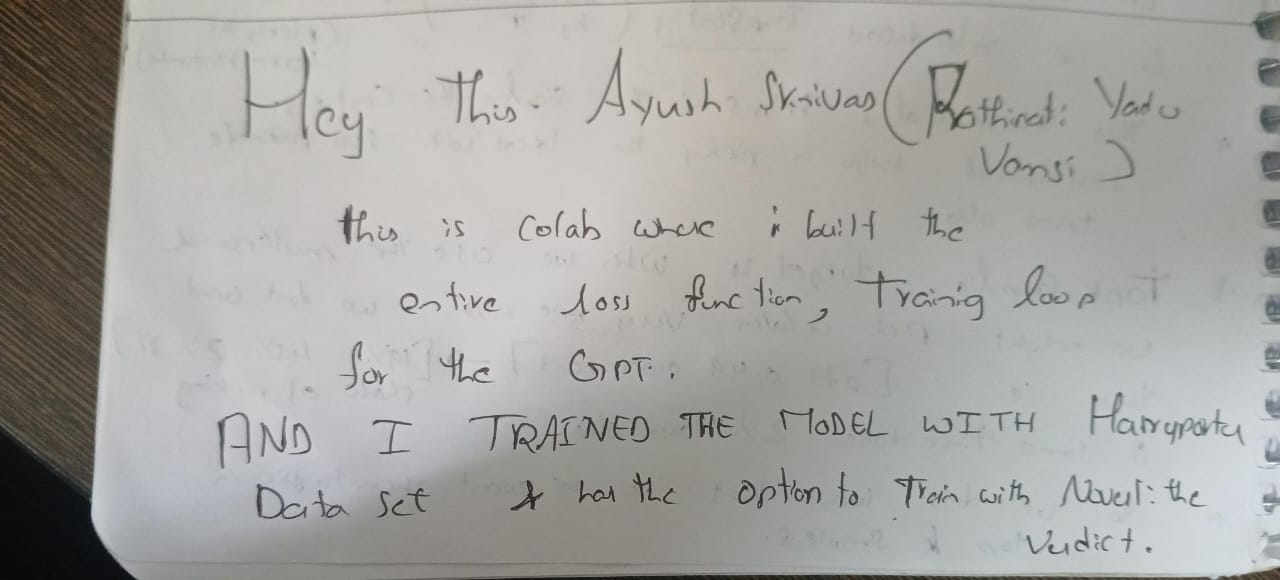

## **NOTE THE CODE FOR THE GPT MODEL IS WRITTEN IN THE FILE GPT2_model.py FILE PLEASE import it for loading the  model .**
## and also to load the pretraining weights we have to use the gpt_download.py file so it is also in the github so please import it .

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.8 MB/s eta 0:00:00


In [ ]:
!pip install -qU tensorflow tqdm

## Now lets train the GPT-2 Model with "the verdict dataset" note : the dtaset is small novel . we kno wthat traing the gpt is really high so thatswhyw we are training the model with just a novel.

In [ ]:
import torch

In [ ]:
import os
import urllib.request

file_path = "the-verdict.txt"
# file_path = "harry_porter.txt"
# you can download the book at https://github.com/amephraim/nlp/blob/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [ ]:
# text data is stored.
print(text_data[:99])
print("---"*50)
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
------------------------------------------------------------------------------------------------------------------------------------------------------
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


## using the  tiktoken we will  bring the tokenizer of gpt2

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


# remember when ever you are creating the model you need to create
1) dataset class with __init__ and __len__ and __get__ these are must
2) you will give this dataset class to the dataloader and it will take care about the batch sizes and every other loading of data part


In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

# normally the gpt architechture has the context of 1024 but there we are using the 256 for easy pretraing

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


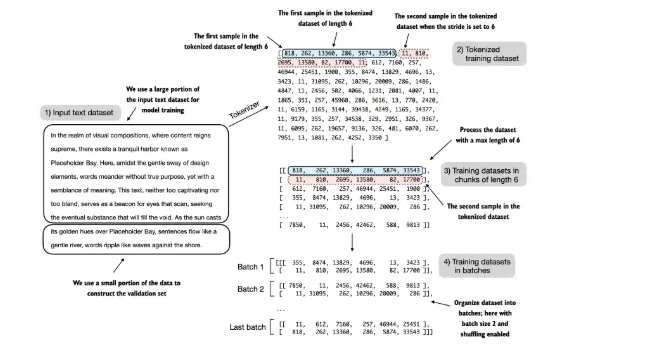

## note that the gptmodel fill code is in the model.py i attached it .

In [ ]:
from GPT2_model import GPTModel

## for reference this is how the model looks like so please check the arch . also the entire code see it if any body want ie i  uploaded in the git hub

In [ ]:
# class GPTModel(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
#         self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
#         self.drop_emb = nn.Dropout(cfg["drop_rate"])

#         self.trf_blocks = nn.Sequential(
#             *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

#         self.final_norm = LayerNorm(cfg["emb_dim"])
#         self.out_head = nn.Linear(
#             cfg["emb_dim"], cfg["vocab_size"], bias=False
#         )

#     def forward(self, in_idx):
#         batch_size, seq_len = in_idx.shape
#         tok_embeds = self.tok_emb(in_idx)
#         pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
#         x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
#         x = self.drop_emb(x)
#         x = self.trf_blocks(x)
#         x = self.final_norm(x)
#         logits = self.out_head(x)
#         return logits

# torch.manual_seed(123)
# model = GPTModel(GPT_CONFIG_124M)
# model.eval();  # Disable dropout during inference

In [ ]:
torch.manual_seed(123)
model =  GPTModel(GPT_CONFIG_124M)

In [ ]:
model.eval();
# note if you remove the ";" it will create a beautiful model arch in the console

In [ ]:
def calc_loss_batch(input_batch , target_batch , model , device ):
  input_batch , target_batch = input_batch.to(device) , target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0 , 1) , target_batch.flatten())
  return loss
# here whts happening is like model give logits we take the pro of target from logits and then we will caluclate the negitve log likelihood


In [ ]:
def calc_loss_loader(data_loader , model , device , num_batches = None ) :
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches , len(data_loader) )

  for i , (input , target ) in enumerate(data_loader):
    if i < num_batches :
      loss = calc_loss_batch(input, target , model , device )
      total_loss += loss.item()
      # .item() is used for cnverting the tensor to a normal python value
    else :
      break

  return total_loss / num_batches
  # this is average loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# note that loading entire data model in single device is must . so please remeber that it is important to load the entire data intot the single device

model.to(device)
torch.manual_seed(123)

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Training loss: 10.98758347829183
Validation loss: 10.98110580444336


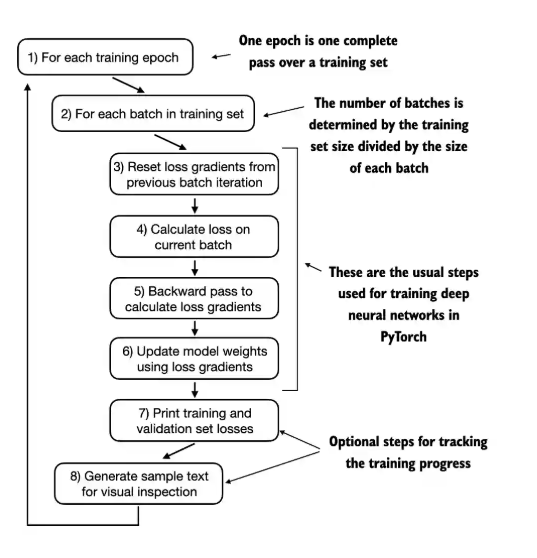

<div class="alert alert-block alert-info">

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch
    
</div>

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"

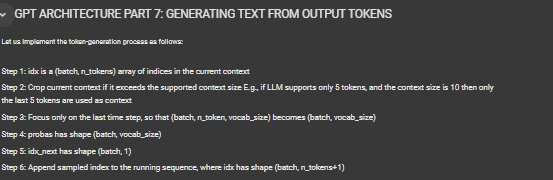

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])
    device = idx.device
    model.to(device)
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

The evaluate_model function calculates the loss over the training and validation set while ensuring the model is in evaluation mode with gradient tracking and dropout disabled when calculating the loss over the training and validation sets

The generate_and_print_sample function is a convenience function that we use to track whether the model improves during the training.

In particular, the generate_and_print_sample function takes a text snippet (start_context) as input, converts it into token IDs, and feeds it to the LLM to generate a text sample using the generate_text_simple function we used earlier

Let's see this all in action by training a GPTModel instance for 10 epochs using an AdamW optimizer and the train_model_simple function we defined earlier.

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

note there are few pottential isues : 1)
this block : ""

if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
""

has the eval function which contains the model.eval() block if we use this block ie model.eval() block every time it might cause some issues but still  i am using as the author suggested it my persona;l opinion is use eval only after one epoch

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [ ]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

As we can see, based on the results printed during the training, the training loss improves drastically, starting with a value of 9.783 and converging to 0.506.

The language skills of the model have improved quite a lot. In the beginning, the model is only able to append commas to the start context ("Every effort moves you,,,,,,,,,,,,") or repeat the word "and".

At the end of the training, it can generate grammatically correct text.

Similar to the training set loss, we can see that the validation loss starts high (9.927) and decreases during the training.

However, it never becomes as small as the training set loss and remains at 6.112 after the 6th epoch.

<br>
we can also see that there is increase in the loss of val after epoch num 6 which is clear sign of overfitting

val data is the data which the model has never seen before so thats why you can understand why the train loss is decreasing and val loss is not decreasing much

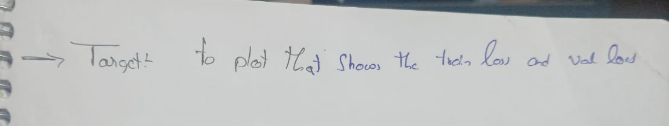

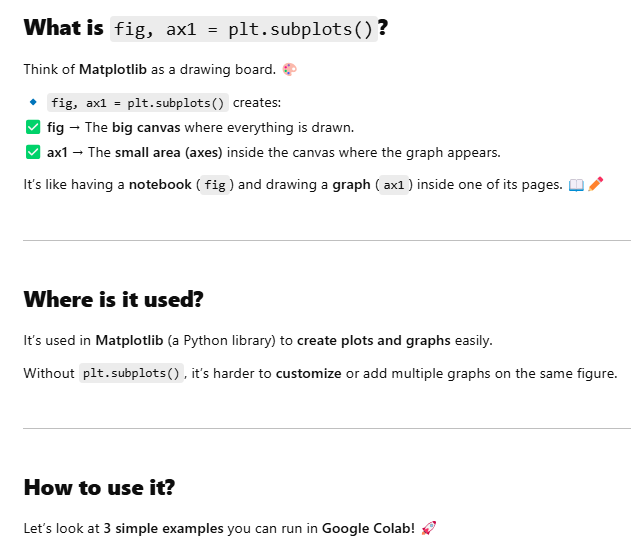

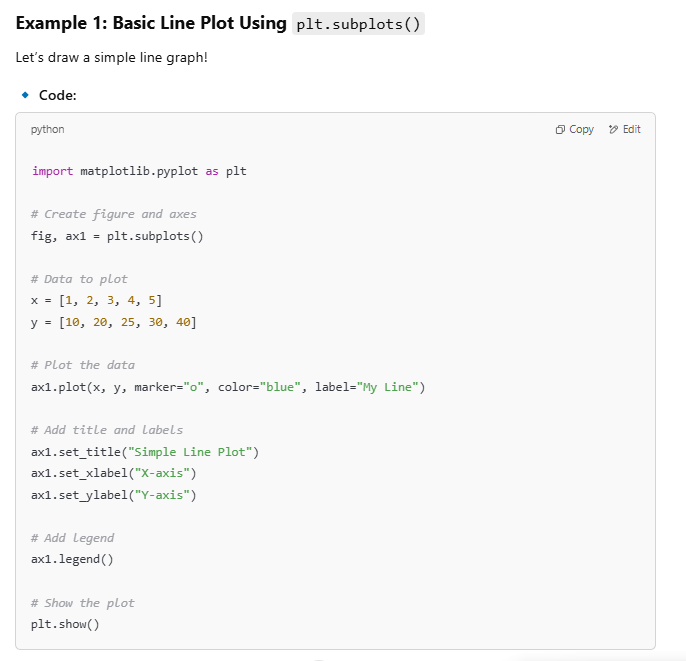

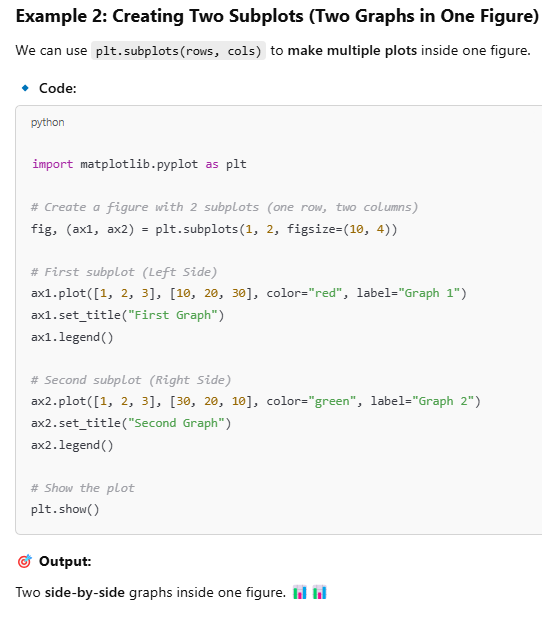

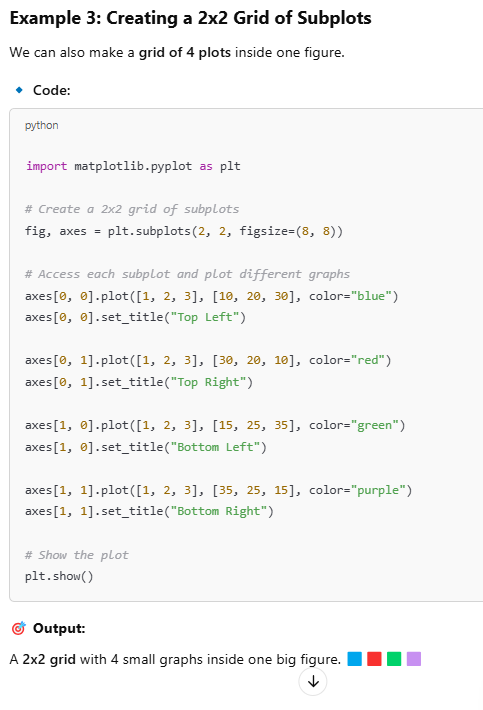

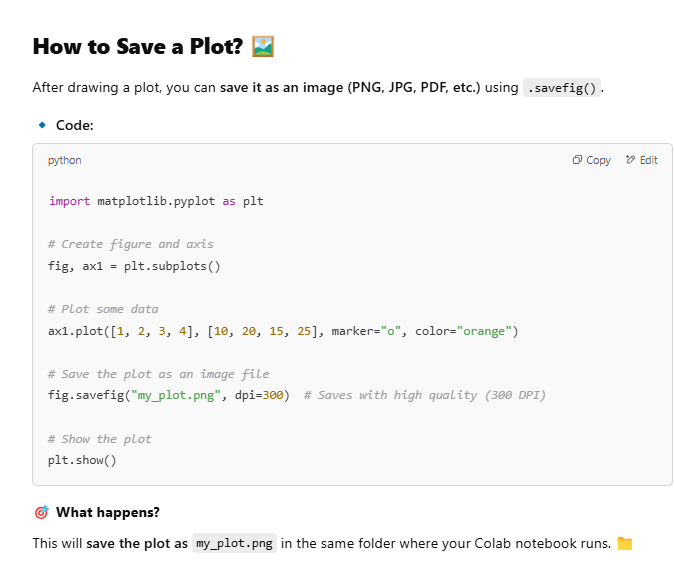

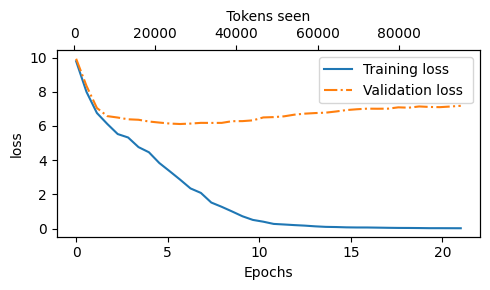

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen , tokens_seen , train_losses , val_losses):
  fig , ax1 = plt.subplots(figsize = (5 , 3))

  ax1.plot(epochs_seen , train_losses , label = "Training loss ")
  ax1.plot(epochs_seen , val_losses ,linestyle = "-." ,  label = "Validation loss ")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("loss")
  ax1.legend(loc = "upper right" )

  ax2 = ax1.twiny()
  # Create a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen , train_losses , alpha = 0 )
  ax2.set_xlabel(" Tokens seen ")

  fig.tight_layout()
  plt.savefig("loss-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0 , num_epochs , len(train_losses))
plot_losses(epochs_tensor , tokens_seen , train_losses , val_losses )






Both the training and validation losses start to improve for the first epoch. However, the losses start to diverge past the second epoch.

This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfitting to the training data.

We can confirm that the model memorizes the training data verbatim by searching for the generated text snippets, such as "quite insensible to the irony" in the "The Verdict" text file.

This memorization is expected since we are working with a very, very small training dataset and training the model for multiple epochs.

Usually, it's common to train a model on a much, much larger dataset for only one epoch.

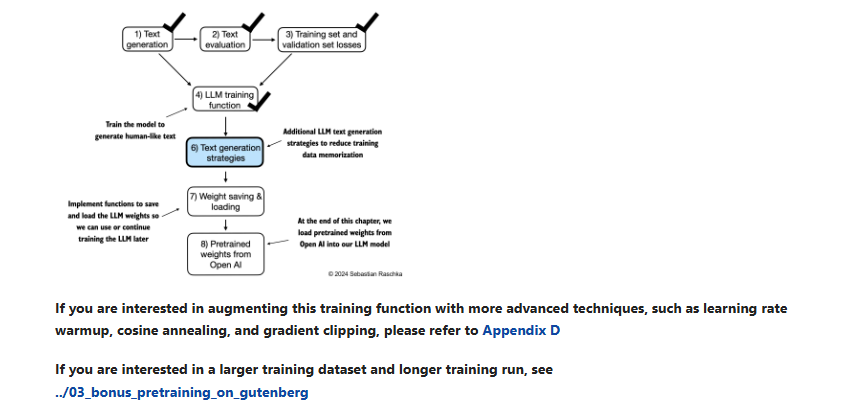

In [ ]:
# task : now see what is the output you are getting for the
# input text "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model ,
    idx = text_to_token_ids("Every effort moves" , tokenizer),
    max_new_tokens = 25 ,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output text :\n " , token_ids_to_text(token_ids , tokenizer))


Output text :
  Every effort moves if I'd never touched a brush."

And his tone told me in a flash that he never thought of anything else


Inference is relatively cheap with a relatively small LLM as the GPT model we trained above, so there's no need to use a GPU for it in case you used a GPU for training it above
Using the generate_text_simple function (from the previous chapter) that we used earlier inside the simple training function, we can generate new text one word (or token) at a time
As explained in section 5.1.2, the next generated token is the token corresponding to the largest probability score among all tokens in the vocabulary

Even if we execute the generate_text_simple function above multiple times, the LLM will always generate the same outputs
We now introduce two concepts, so-called decoding strategies, to modify the generate_text_simple: temperature scaling and top-k sampling
These will allow the model to control the randomness and diversity of the generated text

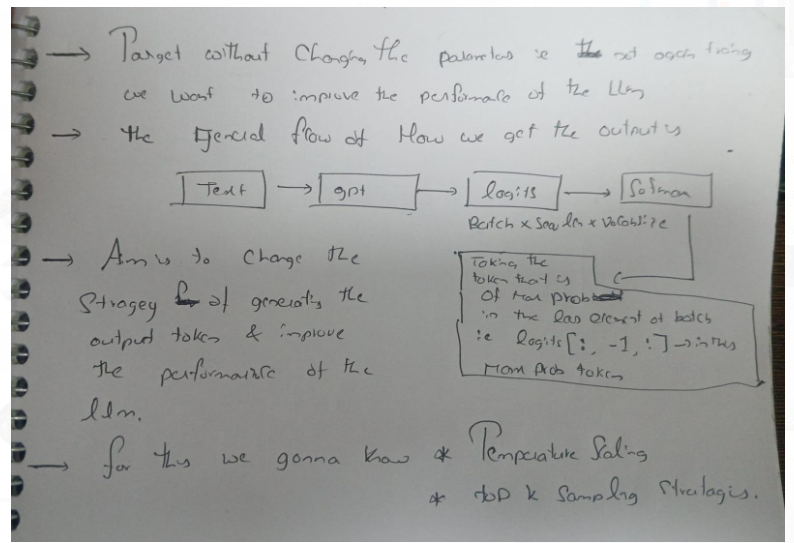

## ** TEMPERATURE SCALING **.

<div class="alert alert-block alert-success">

Previously, inside the generate_text_simple function, we always sampled the token
with the highest probability as the next token using torch.argmax, also known as greedy
decoding.

To generate text with more variety, we can replace the argmax with a function
that samples from a probability distribution (here, the probability scores the LLM generates
for each vocabulary entry at each token generation step).

</div>

<div class="alert alert-block alert-success">

Next, assume the LLM is given the start context "every effort moves you" and
generates the following next-token logits:

</div>

<div class="alert alert-block alert-success">

As discussed in the previous chapter, inside the generate_text_simple, we convert the
logits into probabilities via the softmax function and obtain the token ID corresponding the
generated token via the argmax function, which we can then map back into text via the
inverse vocabulary:

</div>

Here's a little recap of generating the next token, assuming a very small vocabulary for illustration purposes:

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


<div class="alert alert-block alert-success">

To implement a probabilistic sampling process, we can now replace the argmax with the
multinomial function in PyTorch:

</div>

## lets understand how the torch.multinomial works

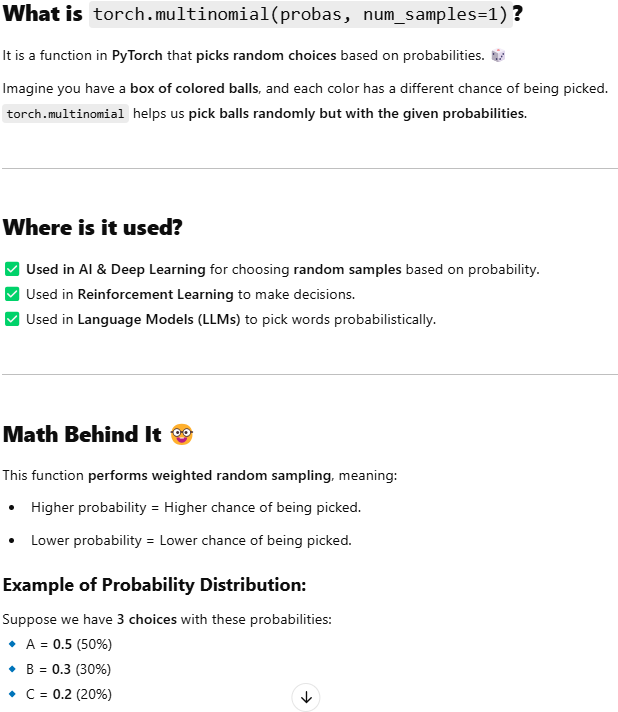

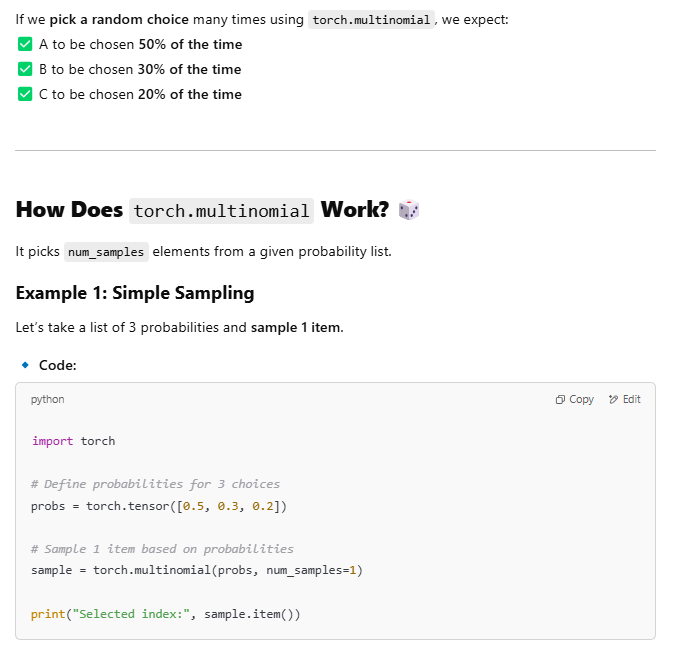

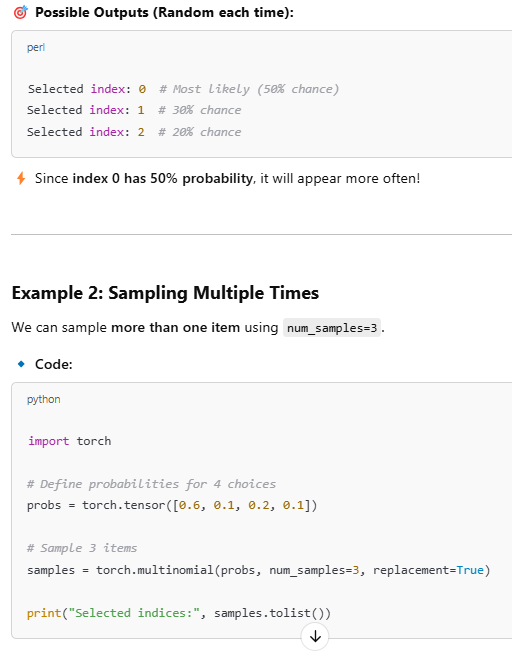

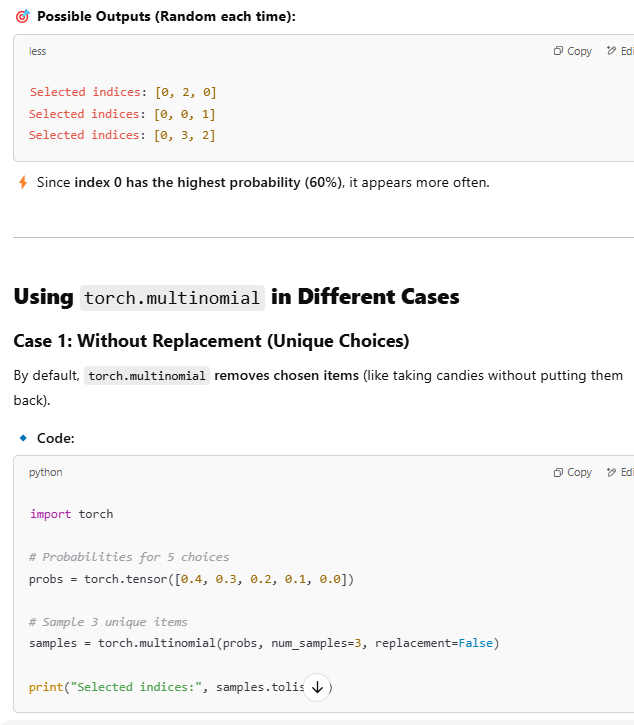

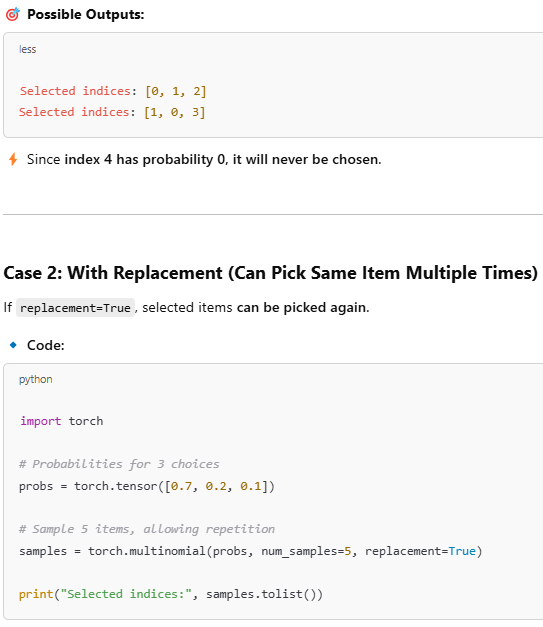

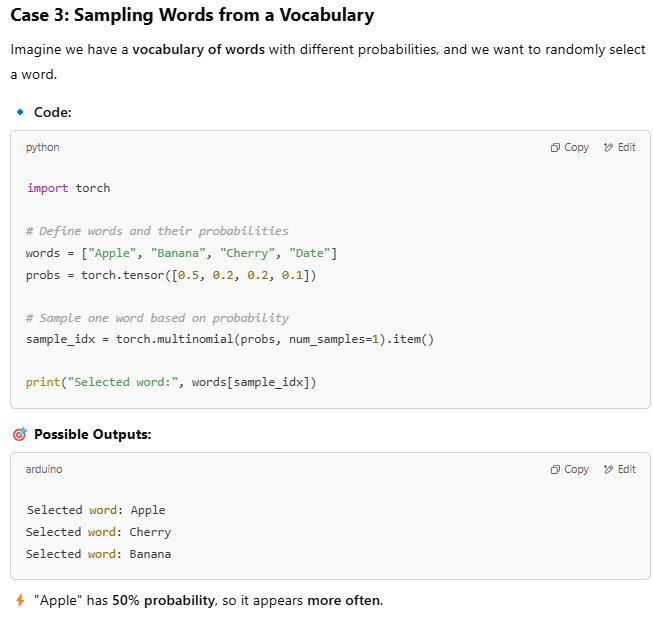

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


The printed output is "forward" just like before. What happened? The multinomial function samples the next token proportional to its probability score.

In other words, "forward" is still the most likely token and will be selected by multinomial most of the time but not all the time.

To illustrate this, let's implement a function that repeats this sampling 1000 times:

In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


torch.bincount(tensor) will generate the elemnet and its correponding freq

<div class="alert alert-block alert-info">

As we can see based on the output, the word "forward" is sampled most of the time (582
out of 1000 times), but other tokens such as "closer", "inches", and "toward" will also
be sampled some of the time.

This means that if we replaced the argmax function with the
multinomial function inside the generate_and_print_sample function, the LLM would
sometimes generate texts such as "every effort moves you toward", "every effort
moves you inches", and "every effort moves you closer" instead of "every effort
moves you forward".
    
</div>

<div class="alert alert-block alert-success">

We can further control the distribution and selection process via a concept called
temperature scaling, where temperature scaling is just a fancy description for dividing the
logits by a number greater than 0:

</div>

<div class="alert alert-block alert-success">

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions.

Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values:

</div>

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

##Multinomial

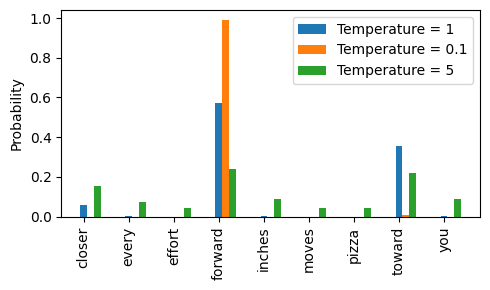

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

<div class="alert alert-block alert-info">

A temperature of 1 divides the logits by 1 before passing them to the softmax function to
compute the probability scores.

In other words, using a temperature of 1 is the same as not
using any temperature scaling.

In this case, the tokens are selected with a probability equal
to the original softmax probability scores via the multinomial sampling function in PyTorch.    
</div>

<div class="alert alert-block alert-info">

Applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function.

Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often.

This can add more variety to the
generated texts but also more often results in nonsensical text.

For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.
    
</div>

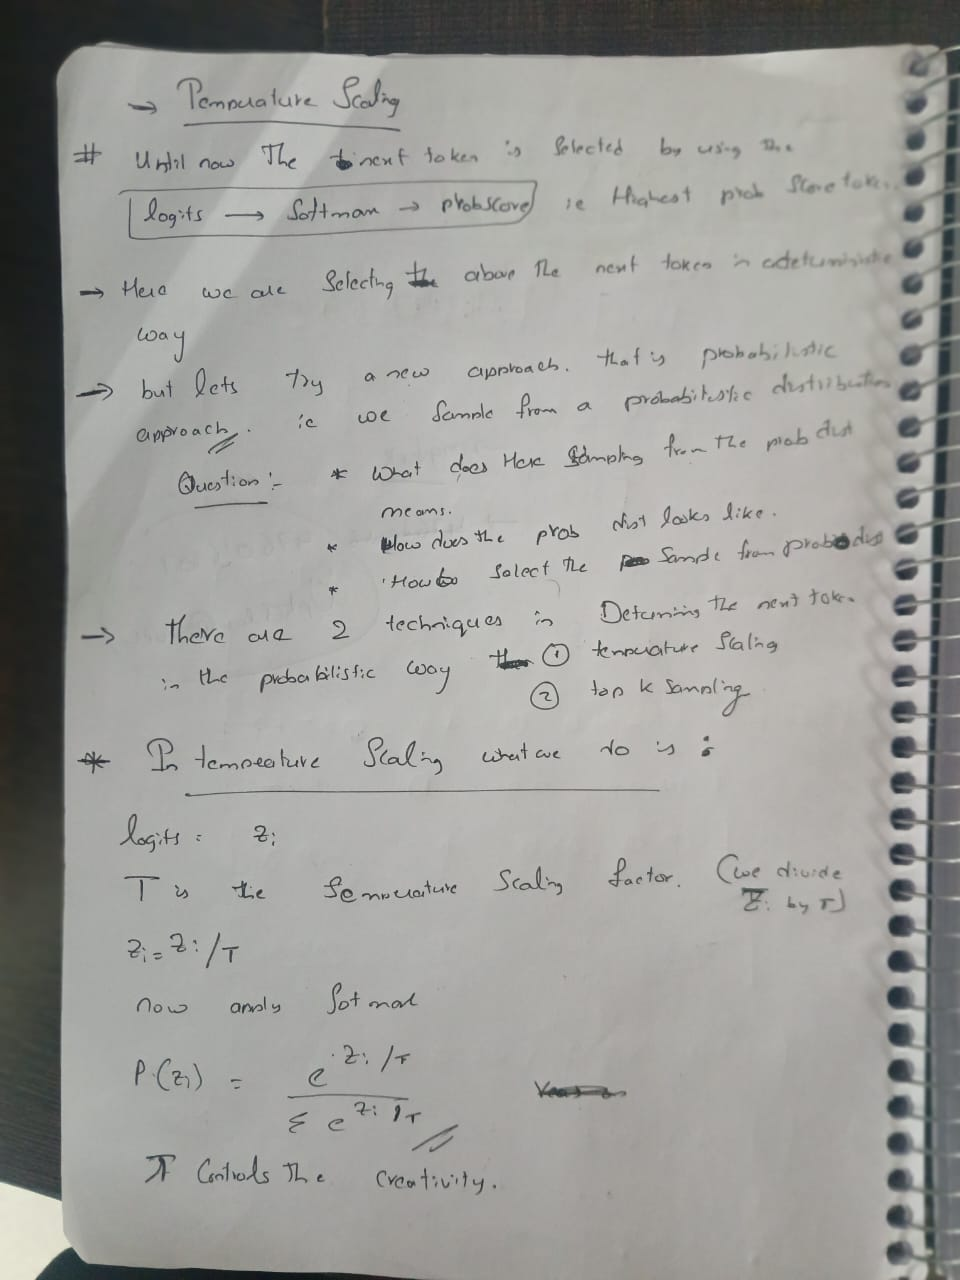

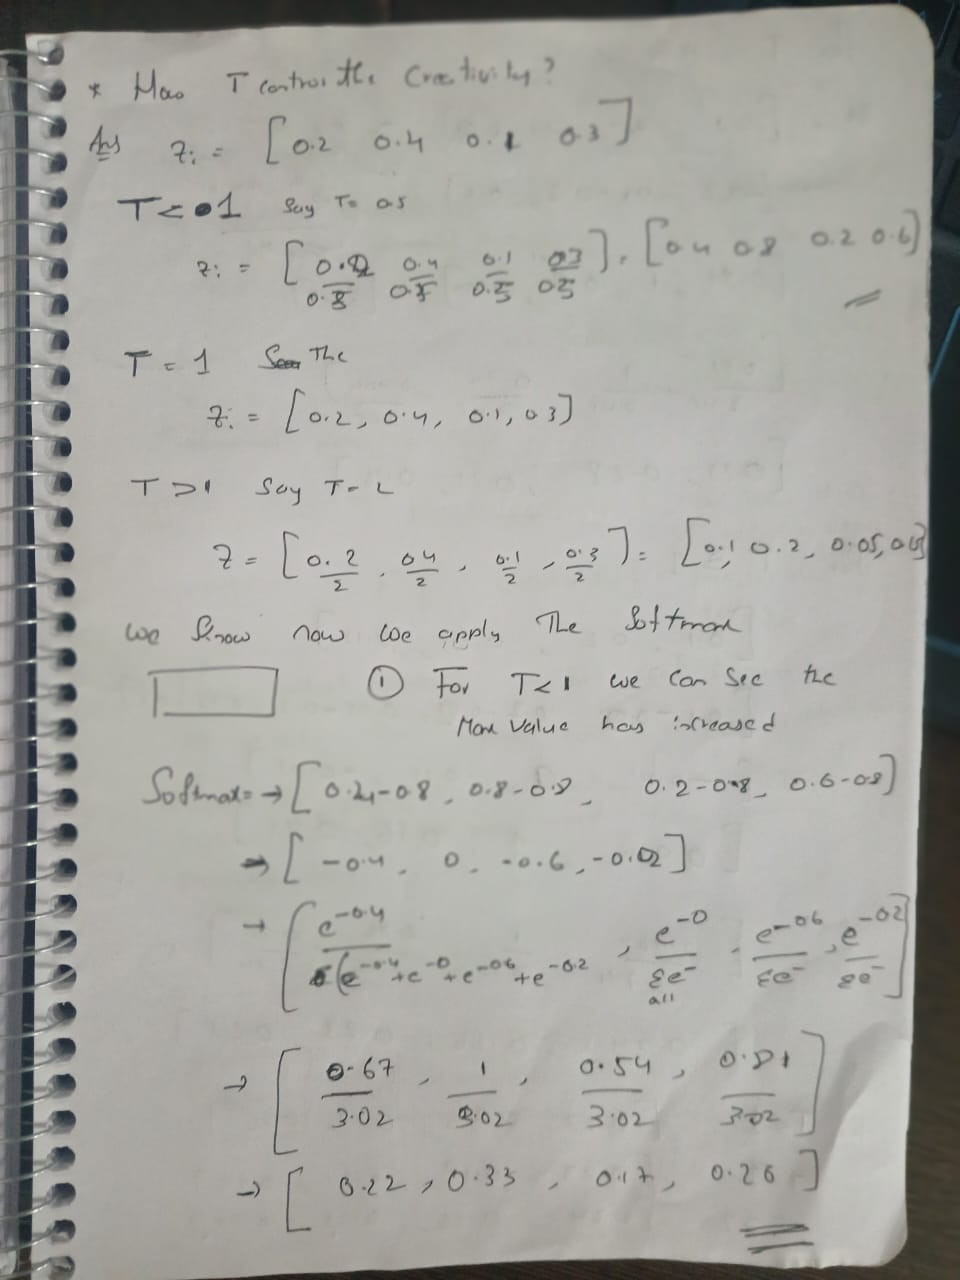

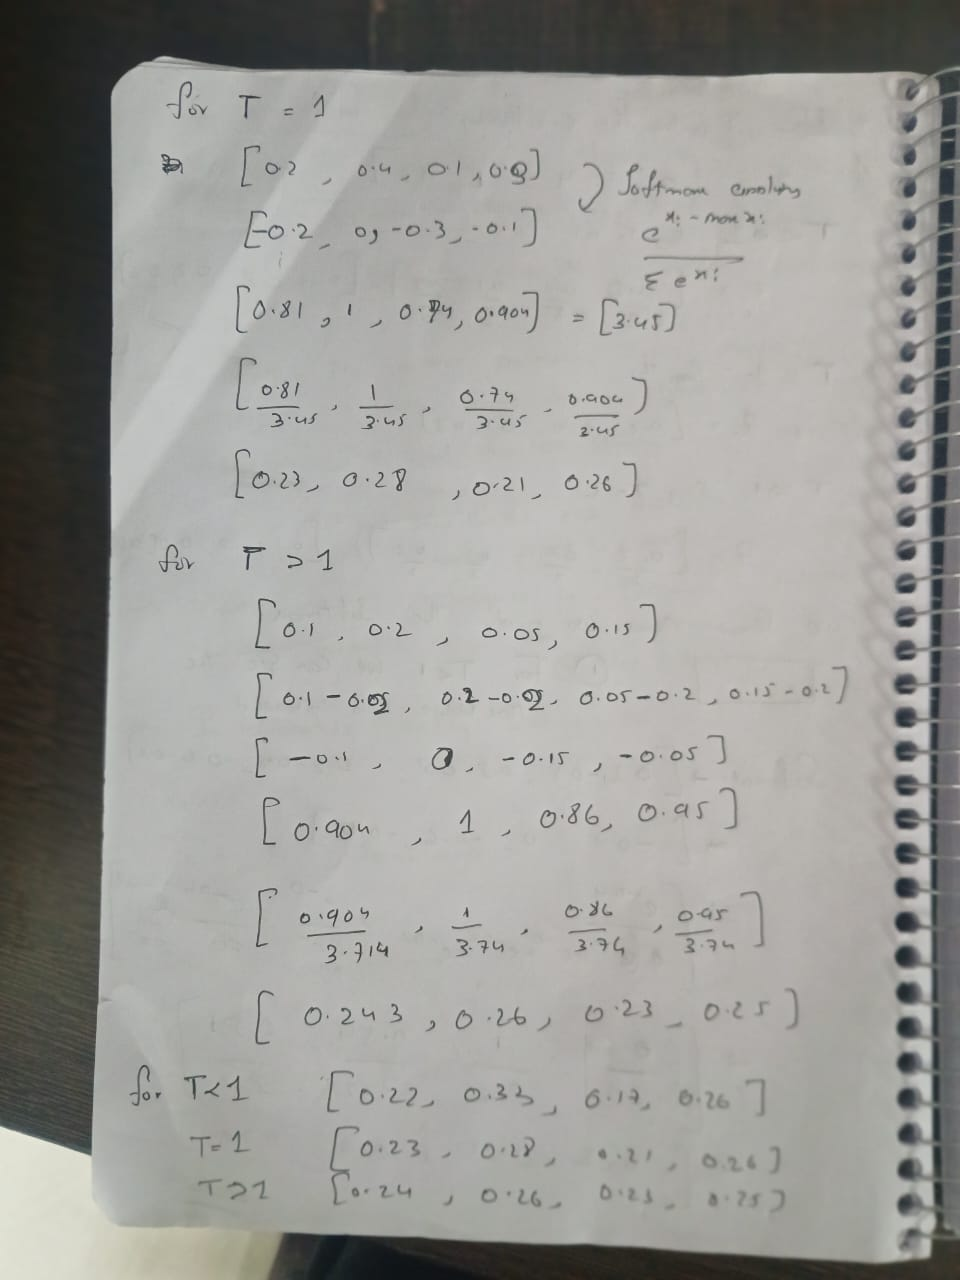

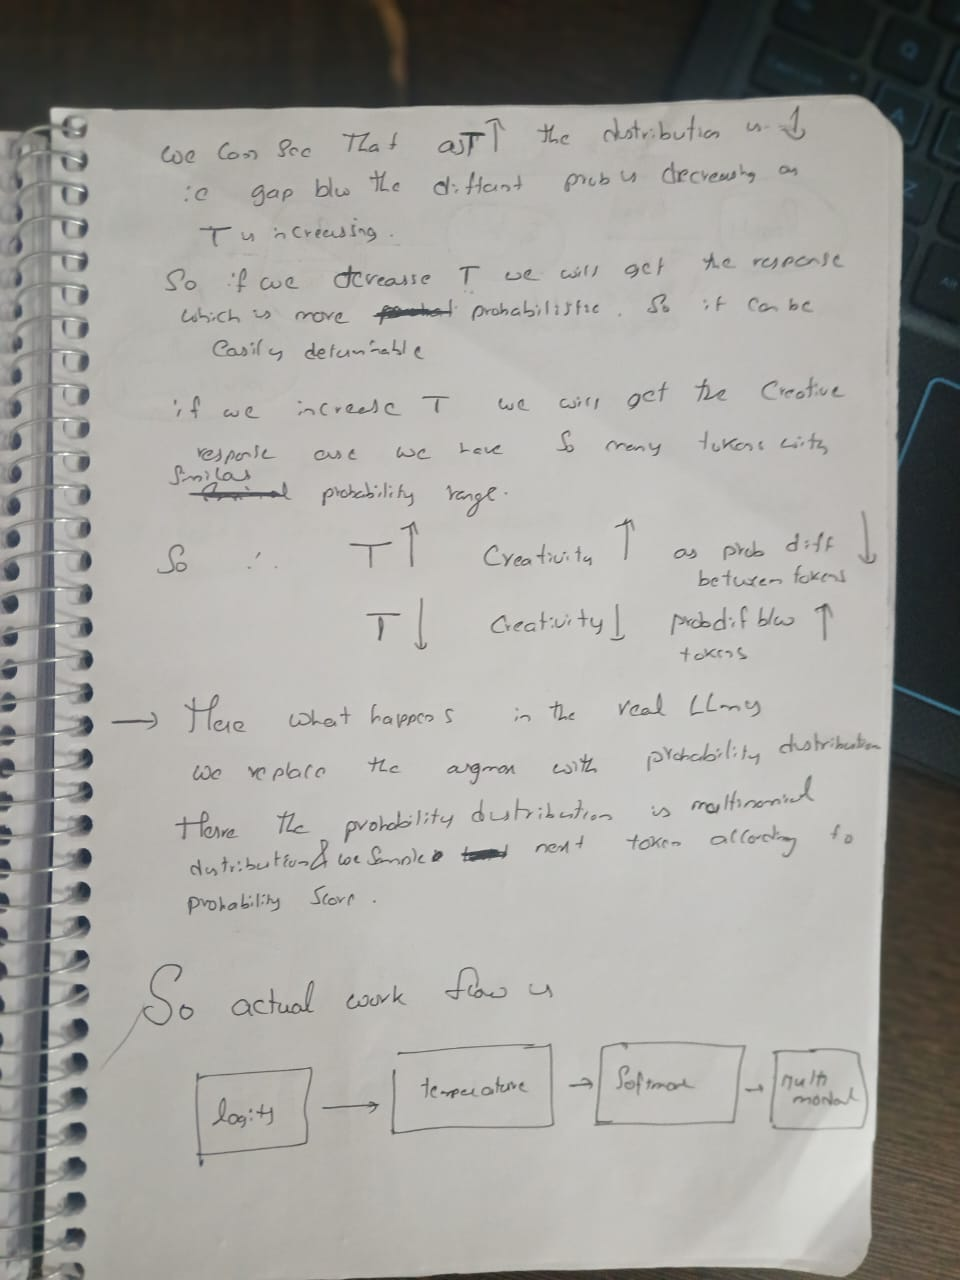

In [ ]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


In [ ]:

print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


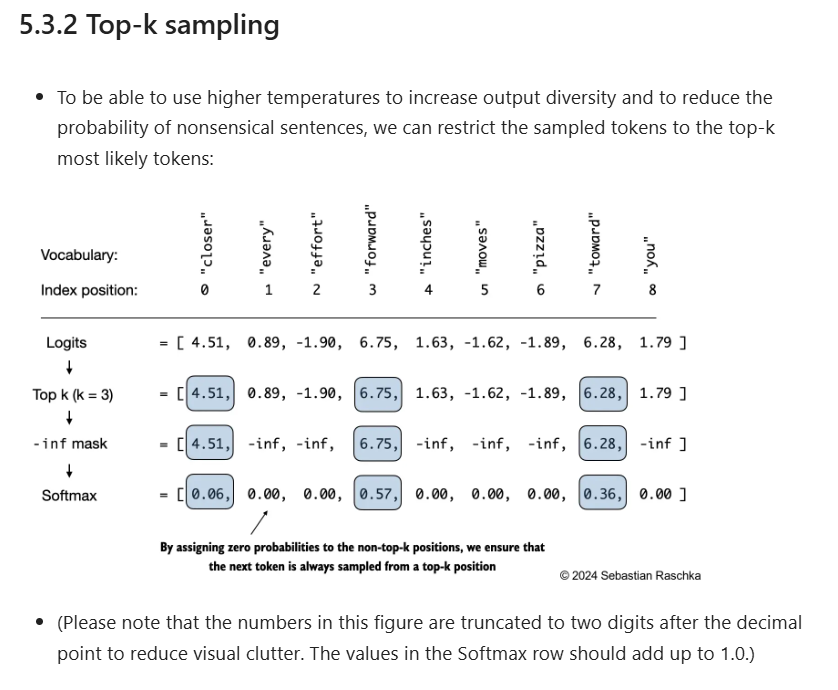

In [ ]:
top_k = 3
top_logits , top_pos = torch.topk(next_token_logits , top_k )

In [ ]:
print(f"top_logits : {top_logits}")
print(f"top_pos : {top_pos}")


top_logits : tensor([6.7500, 6.2800, 4.5100])
top_pos : tensor([3, 7, 0])


In [ ]:
# we want to keep the elemnts that are not top k with -inf
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float("inf")) ,
    other = next_token_logits
)

In [ ]:
print(new_logits)

tensor([4.5100,    inf,    inf, 6.7500,    inf,    inf,    inf, 6.2800,    inf])


In [ ]:
topk_probas = torch.softmax(new_logits , dim = -1 )

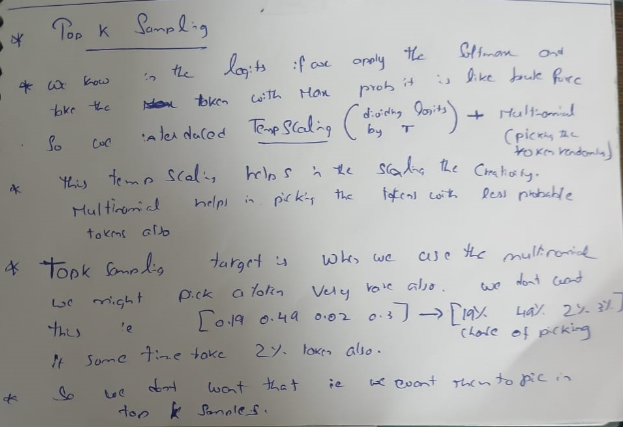

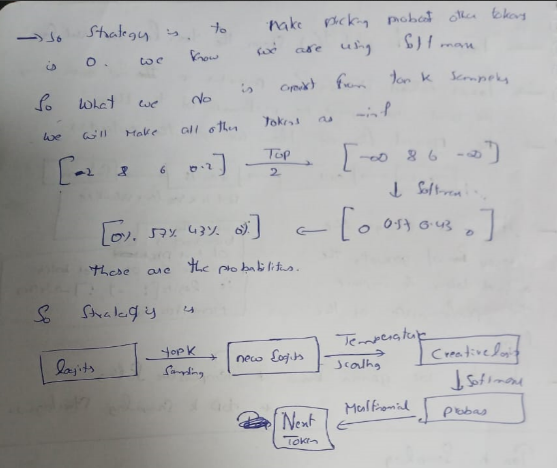

## now lets create a token generation function

In [ ]:
def generate(model , idx , max_new_tokens , context_size , temperature = 1.4 , top_k = None , eos_id = None ):
  device = idx.device
  model.to(device)
  for _ in range(max_new_tokens):
    idx_cond = idx[: , -context_size:]
    # logit cal
    with torch.no_grad():
      logits = model(idx_cond)
    # taking logits in last row of every batch
    logits = logits[ : , -1 , : ]
    # New : Filter logits with top_k sampling
    if top_k is not None :
      top_logits , _ = torch.topk(logits , top_k)
      min_val = top_logits[: , -1]
      logits = torch.where(logits < min_val  , torch.tensor(float("-inf")).to(logits.device) , logits )

    # New : apply temperature scaling
    if temperature > 0.0 :
      logits = logits / temperature
      probas = torch.softmax(logits, dim = -1 )
      idx_next = torch.multinomial(probas , num_samples = 1)

    else:
      idx_next = torch.argmax(logits , dim = -1 , keepdim = True )

    if idx_next == eos_id :
      break

    idx = torch.cat((idx , idx_next) , dim = 1 )


  return idx







In [ ]:
torch.manual_seed(123)
token_ids = generate(
    model = model ,
    idx = text_to_token_ids("Every effort moves you " , tokenizer ),
    max_new_tokens = 15 ,
    context_size = GPT_CONFIG_124M["context_length"],
    top_k = 25 ,
    temperature = 1.6
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


NameError: name 'model' is not defined

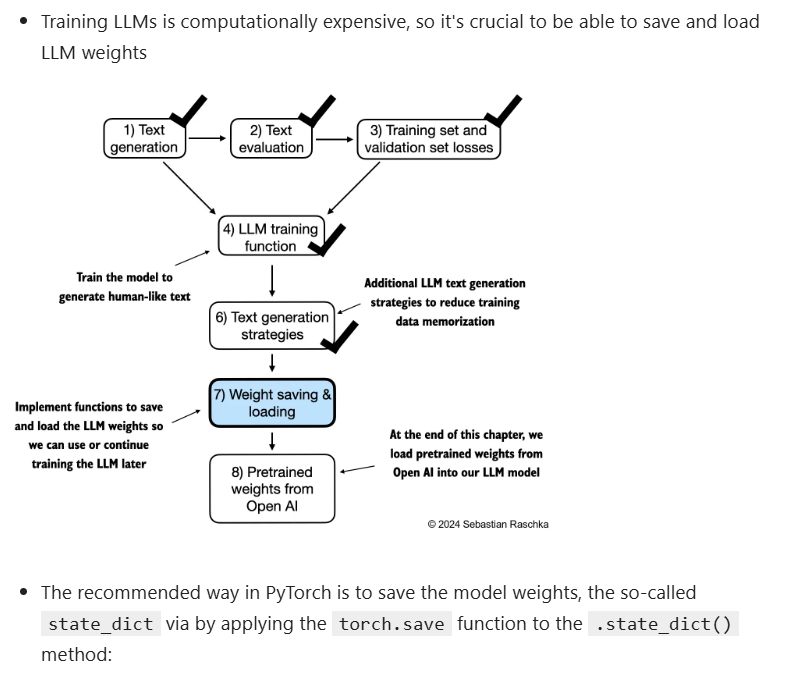

In [ ]:

torch.save(model.state_dict(), "model.pth")

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

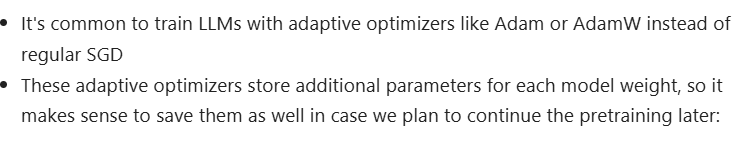

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## ** Download the gpt_download.py file for doing the downloading weights task .**

note that the when we import download_and_load_gpt2 from gpt_download and run the function what happens is it will download the weights and will store the weights in the form of python dict so see the notes below for understanding it clearly .

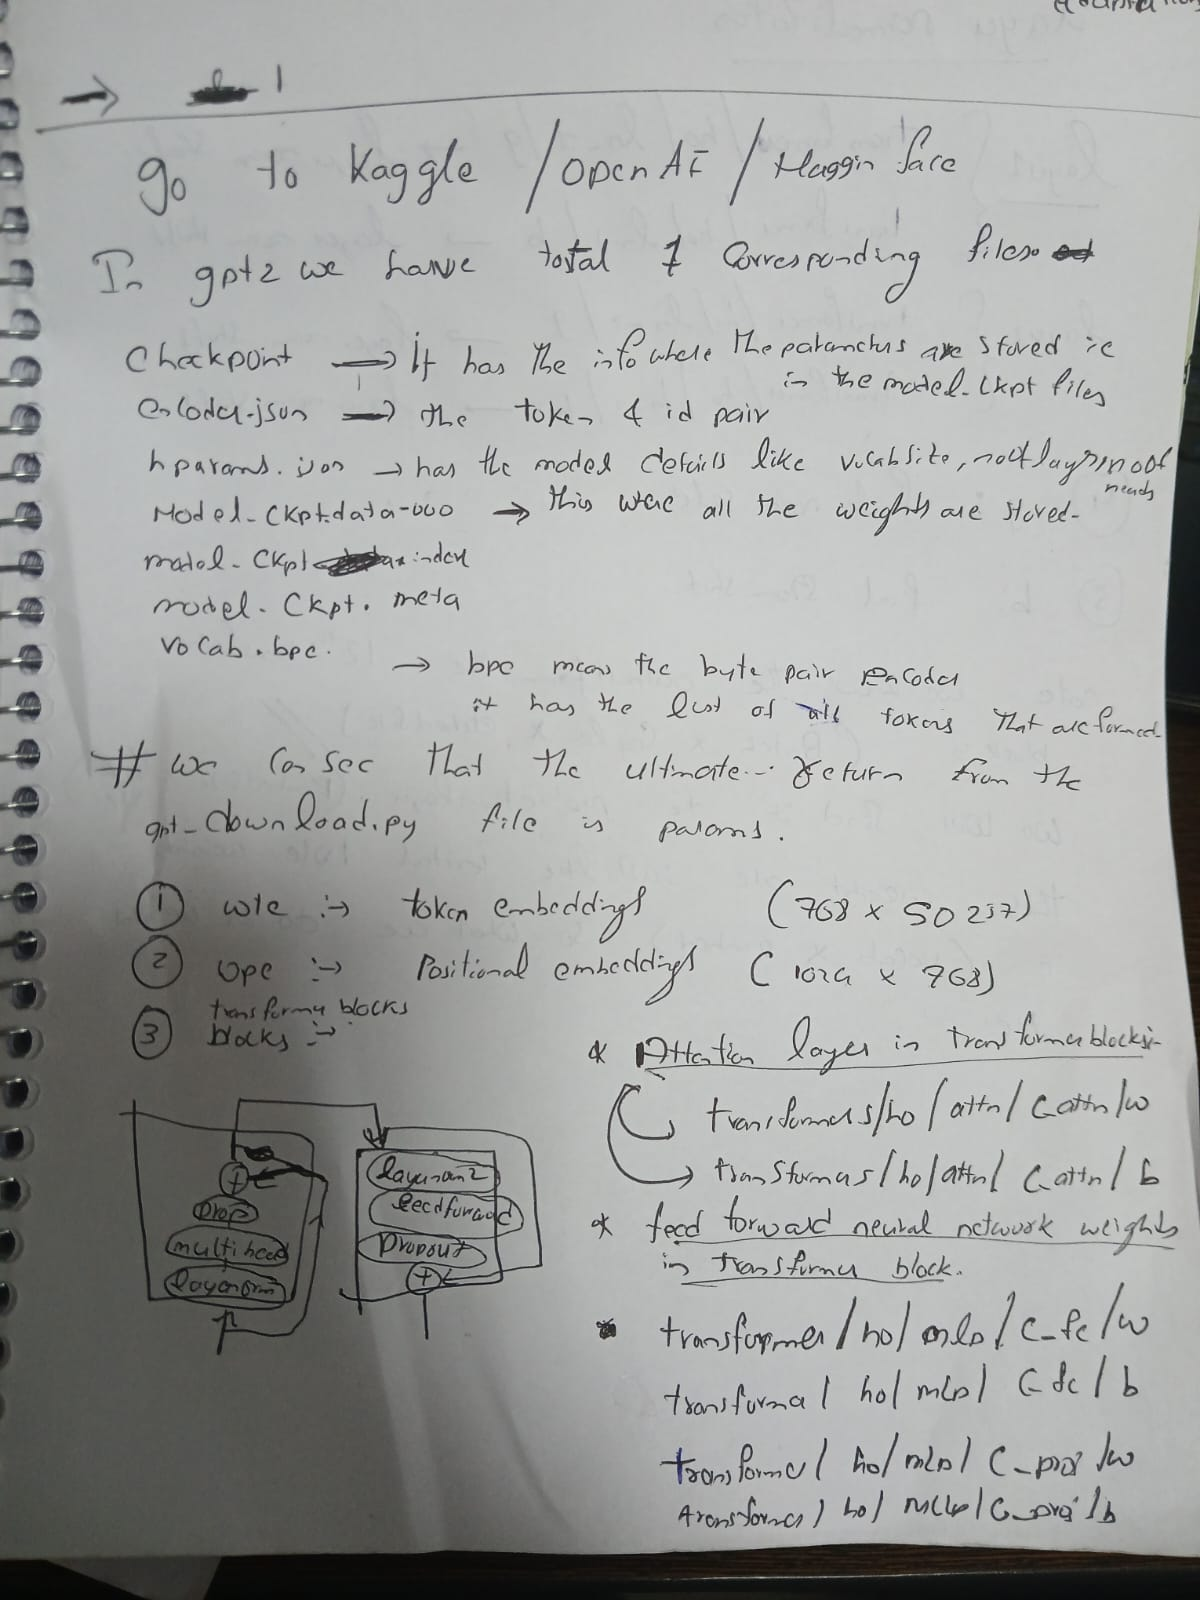

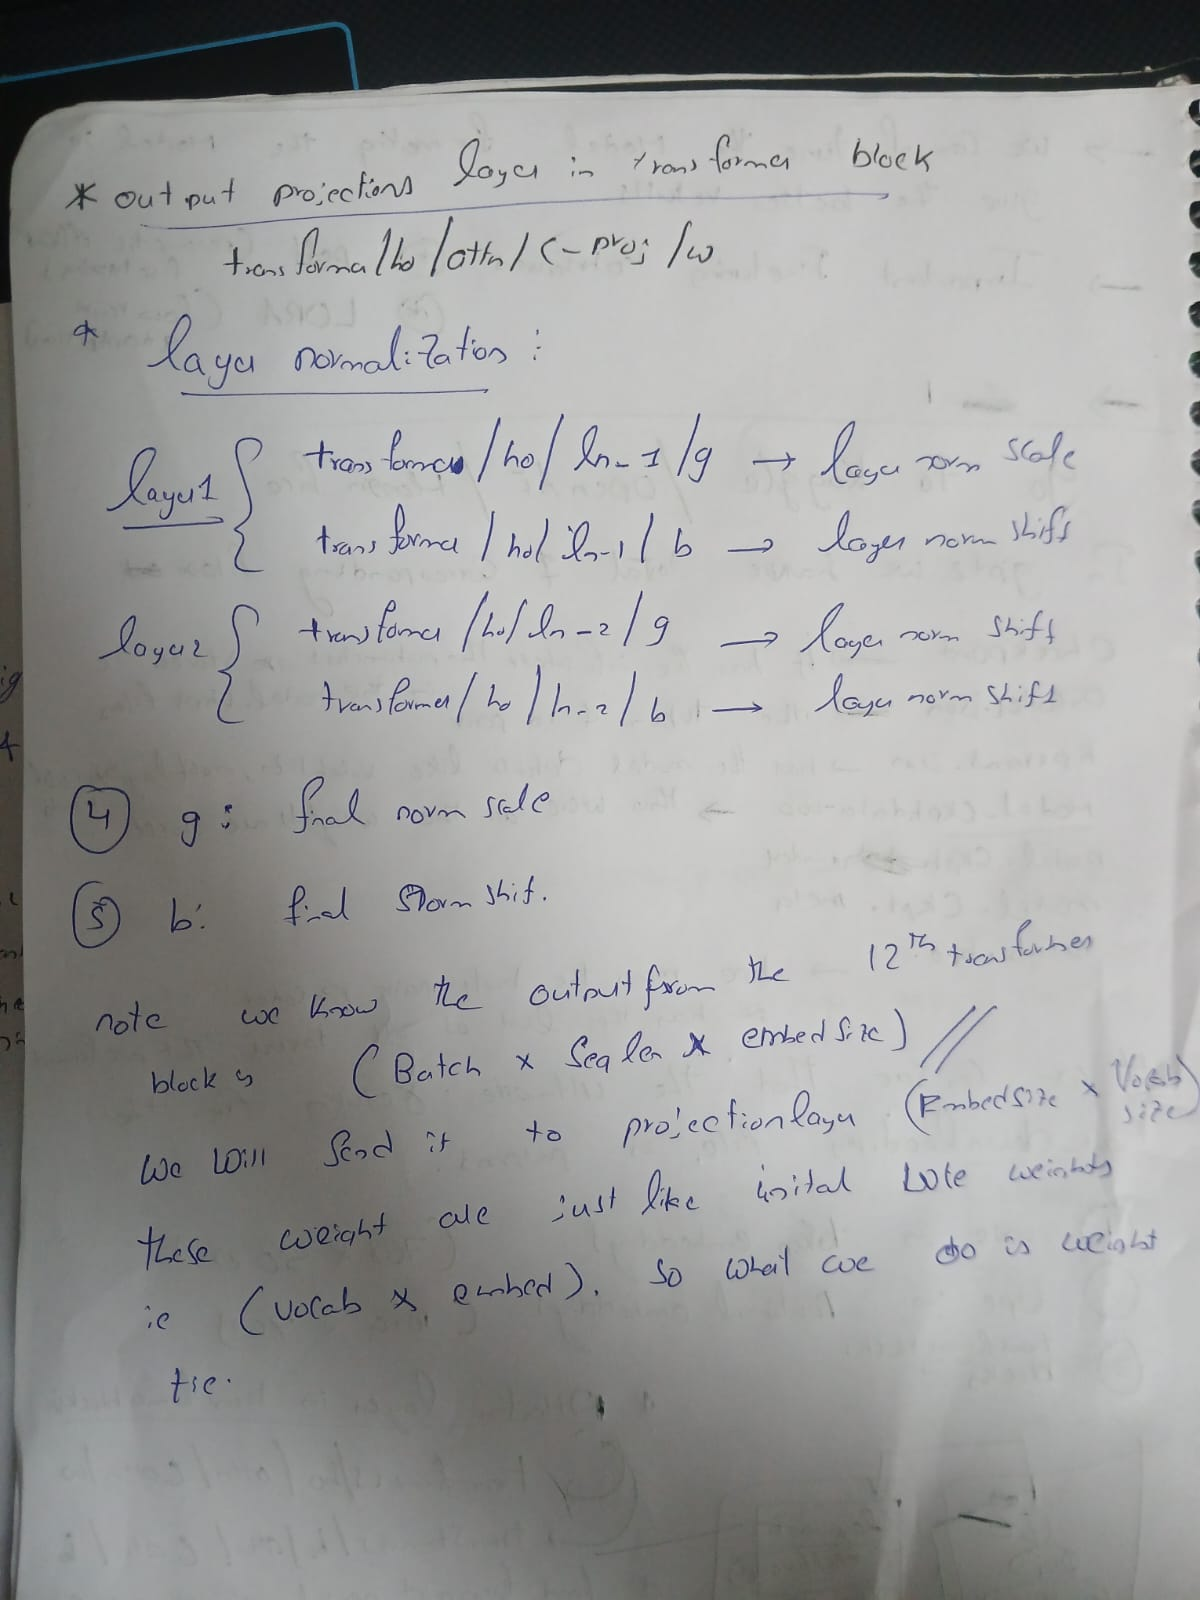

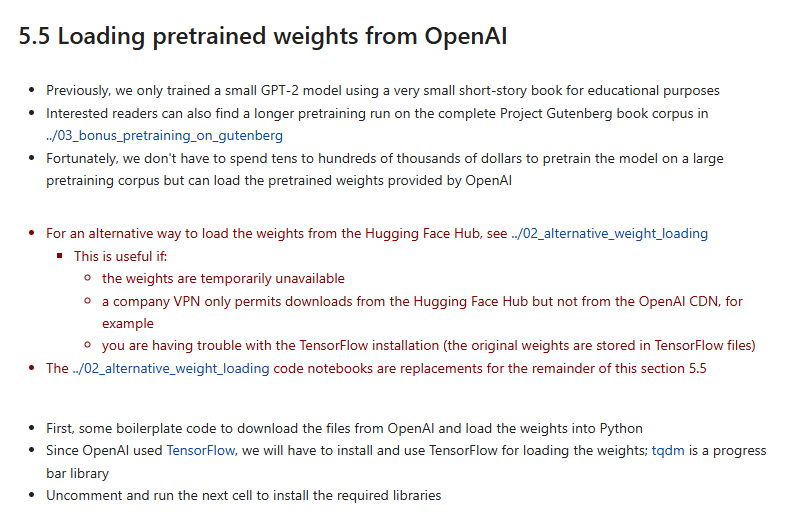

In [ ]:
# params has all the weights all you need to do is convert it accordingly

In [ ]:
pip install tiktoken  tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
from gpt_download import download_and_load_gpt2

ModuleNotFoundError: No module named 'gpt_download'

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

In [ ]:
print("Settings " , settings )


In [ ]:
print("Parameters dictionary keys :" , params.keys())


blocks means transformer blocks <br> wpe means positional layer weights <br> wte means token to vocab layer weights <br>
b is the shift for output norm and g is the shift for chaling in the norm

In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

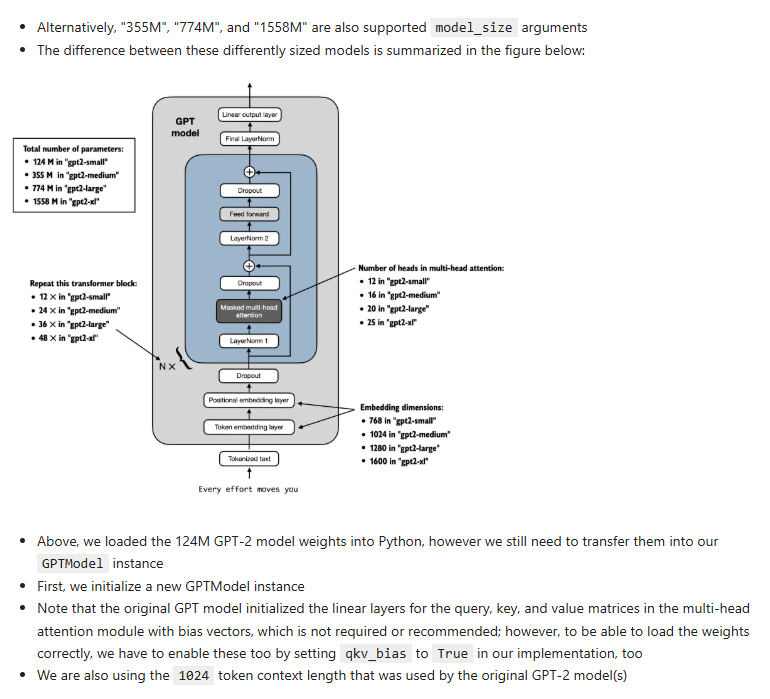

In [ ]:
from GPT2_model import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)


In [ ]:
gpt.eval()

We downloaded and loaded the weights of the smallest GPT-2 model via the download_and_load_gpt2(model_size="124M", ...) setting. However, note that OpenAI also shares the weights of larger models: "355M", "774M", and "1558M".

Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our GPTModel instance.

First, we initialize a new GPTModel instance.

Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting qkv_bias to True in our implementation, too.

We are also using the 1024 token context length that was used by the original GPT-2 model(s)

Careful readers may remember that we used a 256-token length earlier, but the original GPT-2 models from OpenAI were trained with a 1,024-token length, so we have to update the NEW_CONFIG accordingly:

Also, OpenAI used bias vectors in the multi-head attention module's linear layers to implement the query, key, and value matrix computations.

Bias vectors are not commonly used in LLMs anymore as they don't improve the modeling performance and are thus unnecessary.

However, since we are working with pretrained weights, we need to match the settings for consistency and enable these bias vectors:

## in the model.eval() mode the model willnot have the dropout layers as we know tht the dropout is while training only

By default, the GPTModel instance is initialized with random weights for pretraining.

The last step to using OpenAI's model weights is to override these random weights with the weights we loaded into the params dictionary.

For this, we will first define a small assign utility function that checks whether two tensors or arrays (left and right) have the same dimensions or shape and returns the right tensor as trainable PyTorch parameters:

In [ ]:
# it is like we are given two tensors
# left is actual our current omdel params and the right is open ai params we will check them wheter
# they have same weights or not and will return the orginal weights as nn.Parametrs so that we will assign the new weights and also we will
# make them trainable
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

Next, we define a load_weights_into_gpt function that loads the weights from the params dictionary into a GPTModel instance gpt:

Step 1: Setting the model's positional and token embedding weights to those specified in params.

Step 2: Iterate over each transformer block in the model.

Step 3: The np.split function is used to divide the attention and bias weights into three equal parts for the query, key, and value components.

Step 4: The original GPT-2 model by OpenAI reused the token embedding weights in the output layer to reduce the total number of parameters, which is a concept known as weight tying.

## simply hardcoding and hard copying manually the  weights of open ai to out model

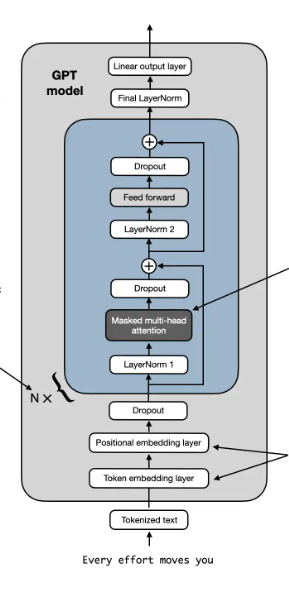

In [ ]:
# first lets see how the token ebeds are there so that we use it
print("token ebeddings:")
print(gpt.tok_emb)
print(gpt.tok_emb.weight.shape)
print("-----" * 50 )
print("params of wte ")
print(params['wte'].shape)
print("-----" * 50 )
print("token ebeddings:")
print(gpt.pos_emb)
print(gpt.tok_emb.weight.shape)
print("-----" * 50 )
print("params of wpe ")
print(params['wpe'].shape)
print("-----" * 50 )

token ebeddings:
Embedding(50257, 768)
torch.Size([50257, 768])
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params of wte 
(50257, 768)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
token ebeddings:
Embedding(1024, 768)
torch.Size([50257, 768])
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
params of wpe 
(1024, 768)
-----------------------------------------------------------------

In [ ]:

# lets see how the blocks of the transformers look like
print(f" no of blocks  {len(params['blocks'])}")
print("---" * 20)
print( f" type of each elemnt in block  {type(params['blocks'][0])}")
print("---" * 20)
print( f" num of elemnts in block[0] in  {len(params['blocks'][0])}")
print("---" * 20)
print( f" keys in block [0] {params['blocks'][0].keys() }")
print("---" * 20)
print(f"ln1 type is {type(params['blocks'][0]['ln_1'])}" )
print("---" * 20)
print(f" keys in ln_1 {params['blocks'][0]['ln_1'].keys()}")
print("---" * 20)
print(f" shape of b (shift paramters ) in ln1 {params['blocks'][0]['ln_1']['b'].shape}")
print("---" * 20)
print(f"shape of gscaling parameters {params['blocks'][0]['ln_1']['g'].shape}")
print("---" * 20)
print("this is same for ln2 also")
print("----" *20)
print(f" type of mlp  {type(params['blocks'][0]['mlp'])}")
print("---" *20)
print(f" type of mlp keys  {params['blocks'][0]['mlp'].keys()}")
print("---" *20)
print(f" mlp has 2 layers as we know one 768 x (4*768)  and (4*768) x 768 so they are cfc and cproj ")
print(f" type of mlp cfc {type(params['blocks'][0]['mlp']['c_fc'])}")
print("---" * 20)
print(f" type of mlp cfc keys  {params['blocks'][0]['mlp']['c_fc'].keys()}")
print("---"*20)
print(f" type of mlp cfc key bais and wei shape  {params['blocks'][0]['mlp']['c_fc']['b'].shape}--- {params['blocks'][0]['mlp']['c_fc']['w'].shape}")
print("---"*20)
print(f" type of mlp cprojection key bais and wei shape  {params['blocks'][0]['mlp']['c_proj']['b'].shape}--- {params['blocks'][0]['mlp']['c_fc']['w'].shape}")
print("----" *20)

# we can see how the parms is
# a list of 12 blocks each block is a dict of 4 keys which are layernorm1 ,
#  layernorm2 , atten block and mlp
#  layernorms will have shift and scale and
#  mlp has expansion and contraction
# the below will expalin  the structure of layer norm 1 , layernorm 2 , mlp



 no of blocks  12
------------------------------------------------------------
 type of each elemnt in block  <class 'dict'>
------------------------------------------------------------
 num of elemnts in block[0] in  4
------------------------------------------------------------
 keys in block [0] dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])
------------------------------------------------------------
ln1 type is <class 'dict'>
------------------------------------------------------------
 keys in ln_1 dict_keys(['b', 'g'])
------------------------------------------------------------
 shape of b (shift paramters ) in ln1 (768,)
------------------------------------------------------------
shape of gscaling parameters (768,)
------------------------------------------------------------
this is same for ln2 also
--------------------------------------------------------------------------------
 type of mlp  <class 'dict'>
------------------------------------------------------------
 type of ml

In [ ]:
# lets analyse the attn block


## this is my multi head attention code and other codes are

##

```
# This is formatted as code
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx
```





```
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

```



In [ ]:
# lets analyse the attention block
print(f"the type of attn in params block 0 transformer block  {type(params['blocks'][0]['attn'])}")
print("---" * 20)
print(f"the keys of attn in params block 0 transformer block  {params['blocks'][0]['attn'].keys()}")
print("---" * 20)
print(f"the type of cporj in params block 0 transformer block attn  {type(params['blocks'][0]['attn']['c_attn'])}")
print("---" * 20)
print(f"the keys of cporj in params block 0 transformer block attn   {params['blocks'][0]['attn']['c_attn'].keys()}")
print("---" * 20)
print(f"the weights and bias shape of the query , key , values of cattn in params block 0 transformer block attn   {params['blocks'][0]['attn']['c_attn']['b'].shape}---{params['blocks'][0]['attn']['c_attn']['w'].shape } ")
print("---" * 20)
print( "<b> see that we have the b shape as 2304 which is 768 x 3 ie all the weights  bias of the query , key value are concatinated </b>" )
print("---" * 20 )
print(f"the weights and bias shape of  cproj in params block 0 transformer block attn   {params['blocks'][0]['attn']['c_proj']['b'].shape}---{params['blocks'][0]['attn']['c_proj']['w'].shape } ")
print("---" * 20)

the type of attn in params block 0 transformer block  <class 'dict'>
------------------------------------------------------------
the keys of attn in params block 0 transformer block  dict_keys(['c_attn', 'c_proj'])
------------------------------------------------------------
the type of cporj in params block 0 transformer block attn  <class 'dict'>
------------------------------------------------------------
the keys of cporj in params block 0 transformer block attn   dict_keys(['b', 'w'])
------------------------------------------------------------
the weights and bias shape of the query , key , values of cattn in params block 0 transformer block attn   (2304,)---(768, 2304) 
------------------------------------------------------------
<b> see that we have the b shape as 2304 which is 768 x 3 ie all the weights  bias of the query , key value are concatinated </b>
------------------------------------------------------------
the weights and bias shape of  cproj in params block 0 transf

 # first wil manually copy the token embed layer weights
  # 1 this is for the transformer block
  # 2 we saw that the weight bias are all tied in single tensor in the params so we have to split
  # ie 2304 is 2 x 768
  # 3 it is of the proj layer in transformer
  # 4 wile loading the weights in the feed forward see once the
  # code of above  of feed forward class we have the sequential layer
  # layer1 (768 x (4 * 768)) -> gelu -> layer2 ((4*768) x (768))
  # 5 we will have the  two layer norm in the transformer blocks we will copy these wiehgts
  # in layer norm the weights are of scaling and the shifting

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In the load_weights_into_gpt function, we carefully match the weights from OpenAI's implementation with our GPTModel implementation.

To pick a specific example, OpenAI stored the weight tensor for the output projection layer for the first transformer block as params["blocks"][0]["attn"]["c_proj"]["w"].

In our implementation, this weight tensor corresponds to gpt.trf_blocks[b].att.out_proj.weight, where gpt is a GPTModel instance.

Developing the load_weights_into_gpt function took a lot of guesswork since OpenAI used a slightly different naming convention from ours.

However, the assign function would alert us if we try to match two tensors with different dimensions.

Also, if we made a mistake in this function, we would notice this as the resulting GPT model would be unable to produce coherent text.

Let's now try the load_weights_into_gpt out in practice and load the OpenAI model weights into our GPTModel instance gpt:

In [ ]:
import torch
load_weights_into_gpt(gpt, params)


In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])
    device = idx.device
    model.to(device)
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
def generate(model , idx , max_new_tokens , context_size , temperature = 1.4 , top_k = None , eos_id = None ):
  device = idx.device
  model.to(device)
  for _ in range(max_new_tokens):
    idx_cond = idx[: , -context_size:]
    # logit cal
    with torch.no_grad():
      logits = model(idx_cond)
    # taking logits in last row of every batch
    logits = logits[ : , -1 , : ]
    # New : Filter logits with top_k sampling
    if top_k is not None :
      top_logits , _ = torch.topk(logits , top_k)
      min_val = top_logits[: , -1]
      logits = torch.where(logits < min_val  , torch.tensor(float("-inf")).to(logits.device) , logits )

    # New : apply temperature scaling
    if temperature > 0.0 :
      logits = logits / temperature
      probas = torch.softmax(logits, dim = -1 )
      idx_next = torch.multinomial(probas , num_samples = 1)

    else:
      idx_next = torch.argmax(logits , dim = -1 , keepdim = True )

    if idx_next == eos_id :
      break

    idx = torch.cat((idx , idx_next) , dim = 1 )


  return idx







In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

In [ ]:
torch.manual_seed(123)
device = 'cpu'
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(" Hello world", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
  Hello world!" I cried in a whisper. In it was Japandroids and his own wife that gave me hope to know the
